In [1]:
#Ideas
#Track down the incorrect predictions and see where they are in the distribition of the rest of the data
#Make sure the weight initialization is random each time
#Can you somehow control the weight initialization to make sure its in a small range?

In [2]:
#HYPERPARAMETERS:
#-Activation function
#-Weight initialisation
#-Loss function
#-Training Algorithms
#-Training Algorithm parameters
#-Learning rate

In [3]:
#Previous Configurations

#Model 1
# model = myNN(12,3,{1:20,2:20,3:15,4:10,5:5})

# learning_rate = 0.01
# criterion = nn.MSELoss()
# # criterion = nn.BCELoss()
# optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle
import random
import copy

In [5]:
with open('almonds_prep.pickle','rb') as file:
    All = pickle.load(file)

In [6]:
def kfold_maker(X,Y,k): #X,Y-> unshuffled input and outputs
    tot = len(X)
    div = int(np.ceil(tot/k))
#     print(div)
    
    if k == 1:
        return X,Y
    cnt1 = 0
    cnt2 = div
    Xfolds = []
    Yfolds = []
    for i in range(k-1):
        
        Xfolds.append(X[cnt1:cnt2,:])
        Yfolds.append(Y[cnt1:cnt2,:])
        
        cnt1 = cnt2
        cnt2 = cnt1 + div
        
    Xfolds.append(X[cnt1:,:])
    Yfolds.append(Y[cnt1:,:])

    return Xfolds,Yfolds

def myMSE(pred,true):
    return ((pred-true)**2).mean()

def CELoss(pred,true):
    n_samples = pred.shape[0] #Number of training examples
    n_outputs = pred.shape[1] #Number of outputs
    predd = pred + 1e-16
    log_term = torch.log(predd)
    ans = (true*log_term).sum()/(n_samples*n_outputs)
    
    return ans

def convert(yout):
    y_out = copy.deepcopy(yout)
    for h in range(y_out.shape[0]):
        y_out[h][y_out[h] == y_out[h].max()] = 1
        y_out[h][y_out[h] != y_out[h].max()] = 0
    return y_out

def data_shuffler(X,Y,Y_binary):
    idxs = np.arange(0,len(X))
    random.shuffle(idxs)
    
    X_new = X[idxs]
    Y_new = Y[idxs]
    Y_binary_new = Y_binary[idxs]
    return X_new,Y_new,Y_binary_new

def batch_maker(X,Y,Y_binary,num_batches): #X,Y-> shuffled input and outputs
    tot = len(X)
    div = int(np.ceil(tot/num_batches))
#     print(div)
    
    if num_batches == 1:
        return X,Y,Y_binary
    cnt1 = 0
    cnt2 = div
    Xbatch = []
    Ybatch = []
    Y_binary_batch = []
    for i in range(num_batches-1):
        
        Xbatch.append(X[cnt1:cnt2,:])
        Ybatch.append(Y[cnt1:cnt2])
        Y_binary_batch.append(Y_binary[cnt1:cnt2,:])

        cnt1 = cnt2
        cnt2 = cnt1 + div
        
    Xbatch.append(X[cnt1:,:])
    Ybatch.append(Y[cnt1:])
    Y_binary_batch.append(Y_binary[cnt1:,:])

    return Xbatch,Ybatch,Y_binary_batch

def accuracy_calc(ytrain_pred, ytrain_target, ytest_pred, ytest_target):
    
    cnt_train = 0

    for h in range(len(ytrain_pred)):
        if sum(ytrain_pred[h,:] == ytrain_target[h,:]) < ytrain_target.shape[1]:
            cnt_train = cnt_train + 1
    incorr_pred_train = cnt_train

    cnt_test = 0
    for j in range(len(ytest_pred)):
        if sum(ytest_pred[j,:] == ytest_target[j,:]) < ytest_target.shape[1]:
            cnt_test = cnt_test + 1
    incorr_pred_test = cnt_test
    return incorr_pred_train, incorr_pred_test

In [7]:
class myNN(nn.Module):
    
    def __init__(self,n_input_features,n_output_features,n_layers_neurons):
        """
        n_input_features = Number of input features
        n_output_features = Number of output features
        n_layers_neurons = Dictionary of HIDDEN layer number and number of neurons in layer
           e.g.  3 hidden layers with 4, 2, and 7 neurons, respectively==> {1:4, 2: 2, 3: 7}
        
        """
        
        super().__init__()
        self.n_hidden_layers = len(list(n_layers_neurons)) #number of hidden layers
        #Creating all the layers
        
        self.layers = nn.ModuleList([nn.Linear(in_features = n_input_features, out_features = n_layers_neurons[1])])#First hidden layer
        
        for n in range(len(n_layers_neurons)-1):
            
            #All hidden layers
            self.layers.append(nn.Linear(in_features = n_layers_neurons[n+1], out_features = n_layers_neurons[n+2]))
            
        self.layers.append(nn.Linear(in_features = n_layers_neurons[list(n_layers_neurons)[-1]], out_features = n_output_features)) #Output layer

        
    def forward(self,x):
        
        #Hidden layers
        ys = []
        ys.append(nn.Tanh()(self.layers[0](x)))
#         print('First layer:',ys)
        for i in range(self.n_hidden_layers - 1):
#             print(i)
            net = self.layers[i+1](ys[i])
            ys.append(nn.Tanh()(net)) #Hidden layers
        
        net_output = self.layers[-1](ys[-1])
        output =nn. Softmax(dim=1)(net_output)
        return output,net_output

In [8]:
Xnum = np.vstack((All[0],All[1],All[2]))
print(Xnum.shape)

(2803, 13)


In [9]:
#Classes: 'MAMRA = [1,0,0]', 'SANORA = [0,1,0]', 'REGULAR' = [0,0,1]
Ynum = []
n_classes = 3
for n in range(len(Xnum)):
    if Xnum[n,-1] == "MAMRA":
        Ynum.append([1,0,0,0])
        
    elif Xnum[n,-1] == "SANORA":
        Ynum.append([0,1,0,1])
        
    elif Xnum[n,-1] == "REGULAR":
        Ynum.append([0,0,1,2])
        
    else:
        print(f"Error row index: {n}")

Xnum = Xnum[:,:-1]
Ynum = np.array(Ynum)
print(f"Input shape: {Xnum.shape}")
print(f"Output shape: {Ynum.shape}")

Input shape: (2803, 12)
Output shape: (2803, 4)


In [10]:
Xnum_train,_,Ynum_train,_ = train_test_split(Xnum,Ynum,test_size = 0.3)
print("X train: ", Xnum_train.shape)
print("Y train: ", Ynum_train.shape)

X_trainb = torch.tensor(Xnum_train.astype(np.float32))
Y_trainb = torch.tensor(Ynum_train,dtype=torch.long)

X train:  (1962, 12)
Y train:  (1962, 4)


In [11]:
criterion = nn.CrossEntropyLoss(reduction = 'none')
n_classes = 3
k = 5 #Number of folds
Xfolds,Yfolds = kfold_maker(X_trainb,Y_trainb,k = k)
print("Number of folds:",len(Xfolds))
print("Percentage of each fold:", len(Xfolds[0])/len(X_trainb)*100)

Number of folds: 5
Percentage of each fold: 20.03058103975535


In [12]:
def CV_model(lr_sgd,momentum,lr_adam,nlow,nhigh,alg_weights):
    
    losses_train_run = [] #Training loss for entire training set of each kfold run
    losses_test_run = []
    num_epochs_run = []

    losses_train_kfold = []
    losses_test_kfold = []

    accuracy_train = []
    accuracy_test = []

    for i in range(k): #for each k-fold run...
        
        model_sgd = myNN(12,3,{1:20,2:20,3:15,4:10,5:5})
        model_adam = copy.deepcopy(model_sgd)
        model_rprop = copy.deepcopy(model_sgd)

        optimizer_sgd = torch.optim.SGD(model_sgd.parameters(),lr = lr_sgd,momentum = momentum)
        optimizer_adam = torch.optim.Adam(model_adam.parameters(),lr = lr_adam)
        optimizer_rprop = torch.optim.Rprop(model_rprop.parameters(),etas = (nlow,nhigh))

        print(f"K = {i + 1}")
        losses_train = [] #Losses for each epoch
        losses_test = []
        
        #Splitting the training and testing folds
        Xfolds_mod = copy.deepcopy(Xfolds)
        Yfolds_mod = copy.deepcopy(Yfolds)

        XTestFold = Xfolds_mod.pop(i) #The fold that will be used for testing
        YTestFold = Yfolds_mod.pop(i)

        XTrainFold = Xfolds_mod #The rest of the folds used for training
        YTrainFold = Yfolds_mod

        #Combining the training folds
        XTrainFold = torch.concatenate(XTrainFold,axis = 0)
        YTrainFold = torch.concatenate(YTrainFold,axis = 0)
        print("Validation training data shape X:", XTrainFold.shape)
        print("Validation training data shape Y:", YTrainFold.shape)

        #Standardising the whole validation data on the training validation data
        sc = StandardScaler()
        XTrainFold = torch.tensor(sc.fit_transform(XTrainFold),dtype = torch.float32)
        XTestFold = torch.tensor(sc.transform(XTestFold),dtype = torch.float32)

        #Splitting the target data into binary and index
        YTrainFold_bin = YTrainFold[:,:-1]
        YTrainFold_idx = YTrainFold[:,-1]

        YTestFold_bin = YTestFold[:,:-1]
        YTestFold_idx = YTestFold[:,-1]

        num_epochs = 0
        tol = 8e-3 #tells us when to stop training
        error = 100
        while (error > tol) and num_epochs < 500:

            num_epochs += 1
            #Shuffling the training validation data
            X_train,Y_train,Y_binary_train = data_shuffler(XTrainFold,YTrainFold_idx,YTrainFold_bin)

            #Divide the training data into batches
            num_batches = 1
            Xbatches, Ybatches,YBinaryBatches = batch_maker(X_train,Y_train,Y_binary_train,num_batches)

        #=======================TRAINING================================
            X_train_batch = Xbatches
            Y_train_batch = Ybatches
            Y_train_binary_batch = YBinaryBatches

            #Forward pass
            ypred_train_sgd,output_net_sgd = model_sgd(X_train_batch)
            ypred_train_adam,output_net_adam = model_adam(X_train_batch)
            ypred_train_rprop,output_net_rprop = model_rprop(X_train_batch)

            #Compute loss
            loss_train_sgd = criterion(output_net_sgd,Y_train_batch).sum()/(n_classes*len(Y_train_batch))
            loss_train_adam = criterion(output_net_adam,Y_train_batch).sum()/(n_classes*len(Y_train_batch))
            loss_train_rprop = criterion(output_net_rprop,Y_train_batch).sum()/(n_classes*len(Y_train_batch))

            #Backward pass
            loss_train_sgd.backward()
            loss_train_adam.backward()
            loss_train_rprop.backward()

            #Hybrid Learning Implementation
            #Save the previous step
            wt_state_sgd = copy.deepcopy(model_sgd.state_dict())
            wt_state_adam = copy.deepcopy(model_adam.state_dict())
            wt_state_rprop = copy.deepcopy(model_rprop.state_dict())

            #Update weights
            optimizer_sgd.step()
            optimizer_adam.step()
            optimizer_rprop.step()

            #Save the current step
            wt1_state_sgd = copy.deepcopy(model_sgd.state_dict())
            wt1_state_adam = copy.deepcopy(model_adam.state_dict())
            wt1_state_rprop = copy.deepcopy(model_rprop.state_dict())

            for sgd_wt1,adam_wt1,rprop_wt1 in zip(model_sgd.named_parameters(),model_adam.named_parameters(),model_rprop.named_parameters()):

                #Compute weight update/ step size-->Current step minus previous step
                sgd_step = wt1_state_sgd[sgd_wt1[0]].clone().detach() - wt_state_sgd[sgd_wt1[0]].clone().detach()
                adam_step = wt1_state_adam[adam_wt1[0]].clone().detach() - wt_state_adam[adam_wt1[0]].clone().detach()
                rprop_step = wt1_state_rprop[rprop_wt1[0]] - wt_state_rprop[rprop_wt1[0]].clone().detach()

                #combine the step sizes
                avg_step = alg_weights[0]*sgd_step + alg_weights[1]*adam_step + alg_weights[2]*rprop_step

                wt_state_sgd[sgd_wt1[0]] += avg_step #add the average step to the old state

                wt_state_adam[adam_wt1[0]] += avg_step #add the average step to the old state

                wt_state_rprop[rprop_wt1[0]] += avg_step #add the average step to the old state

                model_sgd.load_state_dict(wt_state_sgd) #update
                model_adam.load_state_dict(wt_state_adam) #update
                model_rprop.load_state_dict(wt_state_rprop) #update

            optimizer_sgd.zero_grad()
            optimizer_adam.zero_grad()
            optimizer_rprop.zero_grad()


            #After each epoch...
            with torch.no_grad():

                ypred_train_epoch,output_net_train_epoch = model_sgd(X_train)

                ypred_test_epoch,output_net_test_epoch = model_sgd(XTestFold)

#                 loss_train_epoch = criterion(output_net_train_epoch,Y_train).sum()/(n_classes*len(Y_train))
#                 losses_train.append(loss_train_epoch)

#                 loss_test_epoch = criterion(output_net_test_epoch,YTestFold_idx).sum()/(n_classes*len(YTestFold_idx))
#                 losses_test.append(loss_test_epoch)

                error = ((ypred_train_epoch - Y_binary_train)**2).mean()
    #=======================DONE TRAINING================================
#         losses_train_kfold.append(losses_train)
#         losses_test_kfold.append(losses_test)

        if num_epochs == 500:
            print("Training Stopped due to maximum number of iterations reached")

        num_epochs_run.append(num_epochs)

        #TESTING
        with torch.no_grad():

            #Final training and testing for a kfold run
            ypred_train_fold_sgd,output_net_train_fold_sgd = model_sgd(XTrainFold)
            ypred_test_fold_sgd,output_net_test_fold_sgd = model_sgd(XTestFold)
            
#             ypred_train_fold_adam,output_net_train_fold_adam = model_adam(XTrainFold)
#             ypred_test_fold_adam,output_net_test_fold_adam = model_adam(XTestFold)
            
#             ypred_train_fold_rprop,output_net_train_fold_rprop = model_rprop(XTrainFold)
#             ypred_test_fold_rprop,output_net_test_fold_rprop = model_rprop(XTestFold)

            #Training Loss
            loss_train_fold_sgd = criterion(output_net_train_fold_sgd,YTrainFold_idx).sum()/(n_classes*len(YTrainFold_idx))
            losses_train_run.append(loss_train_fold_sgd)
            
#             loss_train_fold_adam = criterion(output_net_train_fold_adam,YTrainFold_idx).sum()/(n_classes*len(YTrainFold_idx))
            
#             loss_train_fold_rprop = criterion(output_net_train_fold_rprop,YTrainFold_idx).sum()/(n_classes*len(YTrainFold_idx))

            #Testing Loss
            loss_test_fold_sgd = criterion(output_net_test_fold_sgd,YTestFold_idx).sum()/(n_classes*len(YTestFold_idx))
            losses_test_run.append(loss_test_fold_sgd)
            
#             loss_test_fold_adam = criterion(output_net_test_fold_adam,YTestFold_idx).sum()/(n_classes*len(YTestFold_idx))
            
#             loss_test_fold_rprop = criterion(output_net_test_fold_rprop,YTestFold_idx).sum()/(n_classes*len(YTestFold_idx))

            
            print(f"SGD Training loss: {loss_train_fold_sgd}")
            print(f"SGD Testing loss: {loss_test_fold_sgd}")
            
#             print(f"Adam Training loss: {loss_train_fold_adam}")
#             print(f"Adam Testing loss: {loss_test_fold_adam}")
            
#             print(f"RPROP Training loss: {loss_train_fold_rprop}")
#             print(f"RPROP Testing loss: {loss_test_fold_rprop}")

            #Accuracy Calculation
            Ypred_train_fold = convert(ypred_train_fold_sgd)
            Ypred_test_fold = convert(ypred_test_fold_sgd)

            cnt_train,cnt_test = accuracy_calc(Ypred_train_fold, YTrainFold_bin, Ypred_test_fold, YTestFold_bin)
            accuracy_train.append(100-(cnt_train/len(Ypred_train_fold)*100))
            accuracy_test.append(100-(cnt_test/len(Ypred_test_fold)*100))
            print("Accuracy Train:", 100-(cnt_train/len(Ypred_train_fold)*100))
            print("Accuracy Test:", 100-(cnt_test/len(Ypred_test_fold)*100))

    losses_train_run = torch.tensor(losses_train_run)
    losses_test_run = torch.tensor(losses_test_run)

    accuracy_train = torch.tensor(accuracy_train)
    accuracy_test = torch.tensor(accuracy_test)

    avg_train_loss = losses_train_run.mean()
    avg_test_loss = losses_test_run.mean()

    avg_train_acc = accuracy_train.mean()
    avg_test_acc = accuracy_test.mean()

    std_loss_train = torch.sqrt(torch.var(losses_train_run))
    std_loss_test = torch.sqrt(torch.var(losses_test_run))
    
    std_acc_train = torch.sqrt(torch.var(accuracy_train))
    std_acc_test = torch.sqrt(torch.var(accuracy_test))
    return {"LossTrain":losses_train_run,
            "LossTest":losses_test_run,
            "AccTrain":accuracy_train,
            "AccTest":accuracy_test,
            "AvgTrainLoss":avg_train_loss,
            "AvgTestLoss":avg_test_loss,
            "AvgTrainAcc":avg_train_acc,
            "AvgTestAcc":avg_test_acc,
            "StdTrainLoss":std_loss_train,
           "StdTestLoss":std_loss_test,
           "AllLossTrain":losses_train_kfold,
           "AllLossTest": losses_test_kfold,
           "TotNumEpochs":num_epochs_run,
           "StdAccTrain":std_acc_train,
           "StdAccTest":std_acc_test}

In [13]:
options = torch.tensor([[1/3,1/3,1/3],[0.7,0.15,0.15],[0.15,0.7,0.15],[0.15,0.15,0.7],[0.425,0.425,0.15],[0.15,0.425,0.425],[0.425,0.15,0.425],[0,0.5,0.5],[0.5,0,0.5],[0.5,0.5,0]])
options.shape

torch.Size([10, 3])

In [14]:
results = []
cntt = 0
for i in range(0,len(options)):
    
    ans =  CV_model(lr_sgd = 1.0,momentum = 0.5,lr_adam = 0.041,nlow = 0.9,nhigh = 1.2,alg_weights = options[i,:])
    
    cntt += 1
    results.append(ans)
    print(f"Done {cntt}")


K = 1
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
SGD Training loss: 0.014936537481844425
SGD Testing loss: 0.027539633214473724
Accuracy Train: 98.59783301465902
Accuracy Test: 97.20101781170483
K = 2
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
SGD Training loss: 0.017131363973021507
SGD Testing loss: 0.021634720265865326
Accuracy Train: 98.40662842574889
Accuracy Test: 98.21882951653944
K = 3
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
SGD Training loss: 0.013457855209708214
SGD Testing loss: 0.013114052824676037
Accuracy Train: 98.91650732950924
Accuracy Test: 98.9821882951654
K = 4
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
SGD Training loss: 0.011913388036191463
SGD Testing loss: 0.01444709300994873
Accuracy 

SGD Training loss: 0.0180811770260334
SGD Testing loss: 0.015523350797593594
Accuracy Train: 98.8527724665392
Accuracy Test: 98.9821882951654
K = 3
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
SGD Training loss: 0.012826776131987572
SGD Testing loss: 0.01245326828211546
Accuracy Train: 99.10771191841937
Accuracy Test: 98.9821882951654
K = 4
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
SGD Training loss: 0.005235759541392326
SGD Testing loss: 0.02411801740527153
Accuracy Train: 99.61759082217974
Accuracy Test: 97.96437659033079
K = 5
Validation training data shape X: torch.Size([1572, 12])
Validation training data shape Y: torch.Size([1572, 4])
SGD Training loss: 0.01659107208251953
SGD Testing loss: 0.028934922069311142
Accuracy Train: 98.9821882951654
Accuracy Test: 97.43589743589743
Done 7
K = 1
Validation training data shape X: torch.Size([1569, 12]

In [15]:
acc_train_grid = torch.zeros(len(options))
acc_test_grid = torch.zeros(len(options))
acc_std_train_grid = torch.zeros(len(options))
acc_std_test_grid = torch.zeros(len(options))
loss_std_train_grid = torch.zeros(len(options))
loss_std_test_grid = torch.zeros(len(options))
loss_train_grid = torch.zeros(len(options))
loss_test_grid = torch.zeros(len(options))

for r in range(0,len(options)):
    
    acc_train_grid[r]  = results[r]["AvgTrainAcc"]
    acc_test_grid[r]  = results[r]["AvgTestAcc"]
    
    acc_std_train_grid[r]  = results[r]["StdAccTrain"]
    acc_std_test_grid[r]  = results[r]["StdAccTest"]
    
    loss_train_grid[r] = results[r]["AvgTrainLoss"]
    loss_test_grid[r] = results[r]["AvgTestLoss"]

    loss_std_train_grid[r] = results[r]["StdTrainLoss"]
    loss_std_test_grid[r] = results[r]["StdTestLoss"]

In [16]:
max_acc_train = acc_train_grid[torch.where(acc_train_grid == acc_train_grid.max())[0]]
max_acc_std_train = acc_std_train_grid[torch.where(acc_train_grid == acc_train_grid.max())[0]]

min_loss_train = loss_train_grid[torch.where(loss_train_grid == loss_train_grid.min())[0]]
min_loss_std_train = loss_std_train_grid[torch.where(loss_train_grid == loss_train_grid.min())[0]]

max_acc_lr_train = options[torch.where(acc_train_grid == acc_train_grid.max())[0]]
min_loss_lr_train = options[torch.where(loss_train_grid == loss_train_grid.min())[0]]

acc_loss_min_train = acc_train_grid[torch.where(loss_train_grid == loss_train_grid.min())[0]]
acc_std_loss_min_train = acc_std_train_grid[torch.where(loss_train_grid == loss_train_grid.min())[0]]
loss_acc_max_train = loss_train_grid[torch.where(acc_train_grid == acc_train_grid.max())[0]]
loss_std_acc_max_train = loss_std_train_grid[torch.where(acc_train_grid == acc_train_grid.max())[0]]


print(f"Maximum Accuracy: {max_acc_train}(+-{max_acc_std_train}), LR: {max_acc_lr_train}, Loss: {loss_acc_max_train} +- {loss_std_acc_max_train}")
print(f"Minimum Loss: {min_loss_train} (+-{min_loss_std_train}), LR: {min_loss_lr_train} Acc: {acc_loss_min_train} +- {acc_std_loss_min_train}")

Maximum Accuracy: tensor([99.2101])(+-tensor([0.2137])), LR: tensor([[0.5000, 0.5000, 0.0000]]), Loss: tensor([0.0190]) +- tensor([0.0055])
Minimum Loss: tensor([0.0129]) (+-tensor([0.0050])), LR: tensor([[0.4250, 0.1500, 0.4250]]) Acc: tensor([99.1591]) +- tensor([0.2932])


In [17]:
max_acc = acc_test_grid[torch.where(acc_test_grid == acc_test_grid.max())[0]]
max_acc_std = acc_std_test_grid[torch.where(acc_test_grid == acc_test_grid.max())[0]]

min_loss = loss_test_grid[torch.where(loss_test_grid == loss_test_grid.min())[0]]
min_loss_std = loss_std_test_grid[torch.where(loss_test_grid == loss_test_grid.min())[0]]

max_acc_lr = options[torch.where(acc_test_grid == acc_test_grid.max())[0]]
min_loss_lr = options[torch.where(loss_test_grid == loss_test_grid.min())[0]]

acc_loss_min = acc_test_grid[torch.where(loss_test_grid == loss_test_grid.min())[0]]
loss_acc_max = loss_test_grid[torch.where(acc_test_grid == acc_test_grid.max())[0]]

print(f"Maximum Accuracy: {max_acc}(+-{max_acc_std}), LR: {max_acc_lr}, Loss: {loss_acc_max}")
print(f"Minimum Loss: {min_loss} (+-{min_loss_std}), LR: {min_loss_lr} Acc: {acc_loss_min}")

Maximum Accuracy: tensor([98.7258])(+-tensor([0.5398])), LR: tensor([[0.4250, 0.4250, 0.1500]]), Loss: tensor([0.0198])
Minimum Loss: tensor([0.0198]) (+-tensor([0.0086])), LR: tensor([[0.4250, 0.4250, 0.1500]]) Acc: tensor([98.7258])


<IPython.core.display.Javascript object>


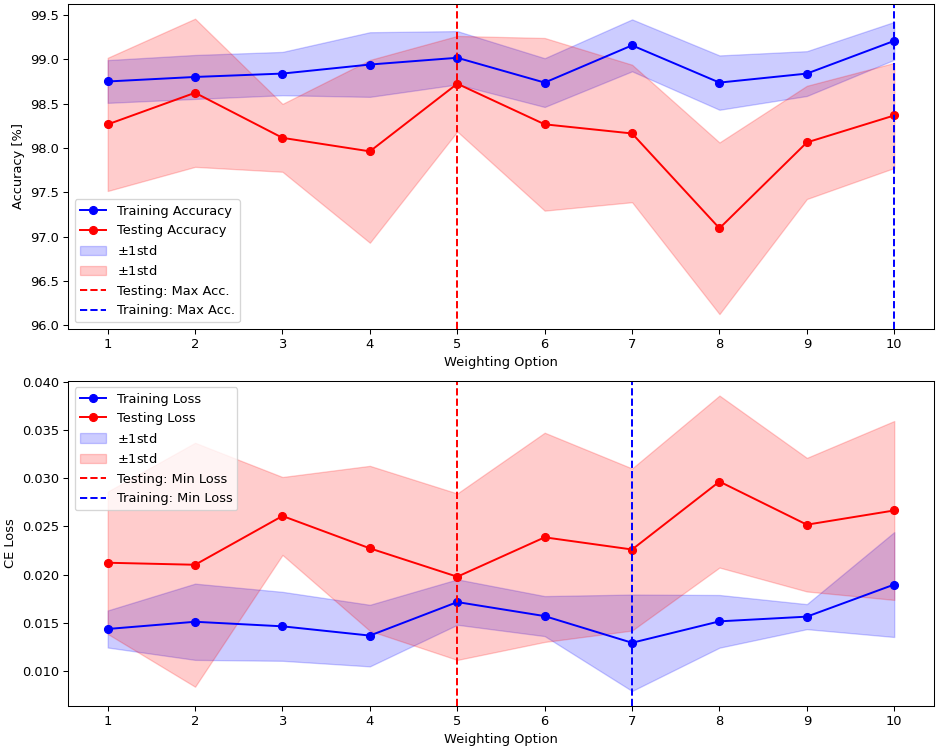

In [30]:
%matplotlib notebook
fig10, ax10 = plt.subplots(2,1,figsize = (10,8),layout = 'constrained')

ax10[0].plot(torch.arange(1,len(options)+ 1),acc_train_grid,color='b',marker = 'o',label = 'Training Accuracy')
ax10[0].plot(torch.arange(1,len(options)+ 1),acc_test_grid,color='r',marker = 'o',label = 'Testing Accuracy')
ax10[0].fill_between(torch.arange(1,len(options)+ 1), acc_train_grid - acc_std_train_grid, acc_train_grid + acc_std_train_grid, alpha=0.2,color='b',label = '$\pm$1std')
ax10[0].fill_between(torch.arange(1,len(options)+ 1), acc_test_grid - acc_std_test_grid, acc_test_grid + acc_std_test_grid, alpha=0.2,color='r',label = '$\pm$1std')
ax10[0].set_xlabel("Weighting Option")
ax10[0].set_ylabel("Accuracy [%]")
ax10[0].legend()
ax10[0].set_xticks(np.arange(1,len(options)+1),np.arange(1,len(options)+1))
ax10[0].axvline(5,linestyle = '--',color='r',label = 'Testing: Max Acc.')
ax10[0].axvline(10,linestyle = '--',color='b',label = 'Training: Max Acc.')



ax10[1].plot(torch.arange(1,len(options)+ 1),loss_train_grid,color='b',marker = 'o',label = "Training Loss")
ax10[1].plot(torch.arange(1,len(options)+ 1),loss_test_grid,color='r',marker = 'o',label = "Testing Loss")
ax10[1].fill_between(torch.arange(1,len(options)+1), loss_train_grid - loss_std_train_grid, loss_train_grid + loss_std_train_grid, alpha=0.2,color='b',label = '$\pm$1std')
ax10[1].fill_between(torch.arange(1,len(options)+1), loss_test_grid - loss_std_test_grid, loss_test_grid + loss_std_test_grid, alpha=0.2,color='r',label = '$\pm$1std')
ax10[1].axvline(5,linestyle = '--',color='r',label = 'Testing: Min Loss')
ax10[1].axvline(7,linestyle = '--',color='b',label = 'Training: Min Loss')
ax10[1].set_xticks(np.arange(1,len(options)+1),np.arange(1,len(options)+1))
ax10[1].set_xlabel("Weighting Option")
ax10[1].set_ylabel("CE Loss")
ax10[1].legend()
ax10[0].legend()

In [31]:
plt.savefig('model4_CV',dpi = 200)